In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import PIL
from PIL import Image
from scipy import fft
import scipy

# Setting up basic data 
### grayscale image and knownn kernel constant over whole image

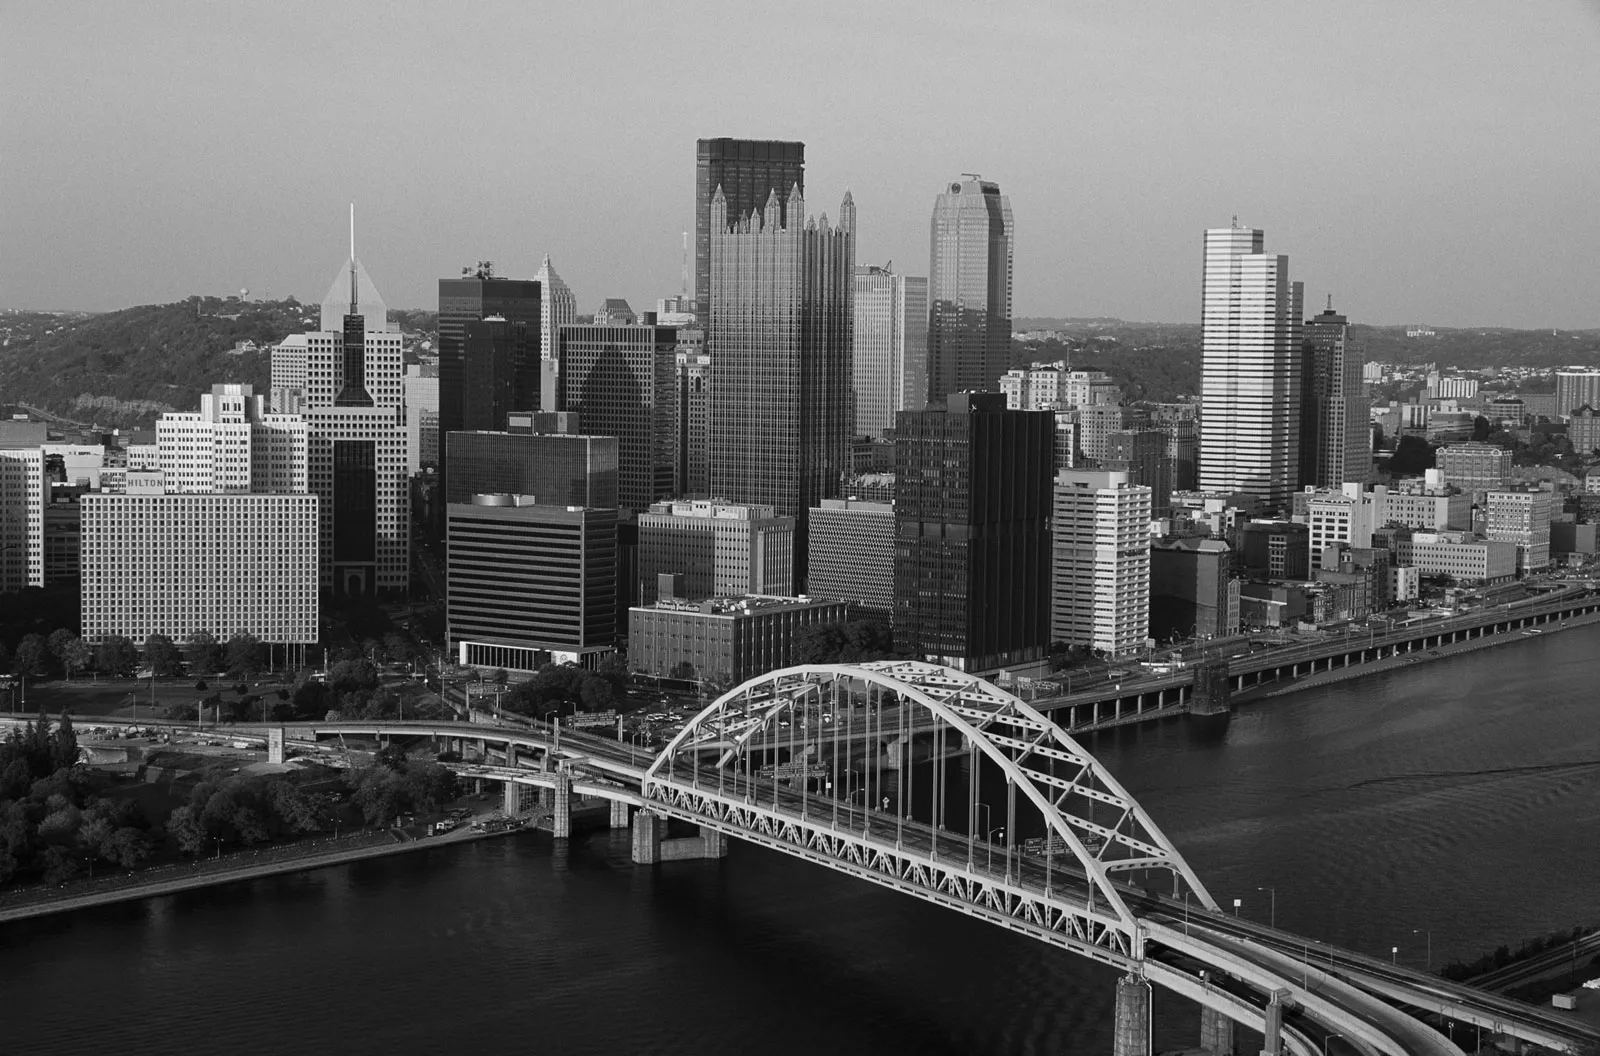

In [12]:
#NOTE: normalize image to [0,1]
img = cv2.imread('../data/pittsburgh.webp', cv2.IMREAD_GRAYSCALE) / 255.0

img_pil = Image.open('../data/pittsburgh.webp').convert('L')  # Convert to grayscale
display(img_pil)

### Synthetic image:

In [13]:
# img = np.zeros((400, 600))

### defining our synthetic kernel:

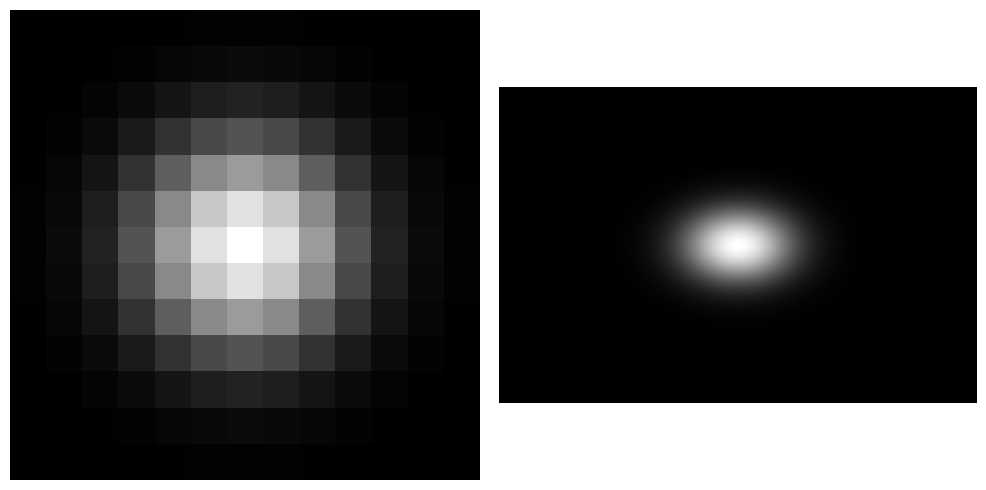

In [14]:
# In image domain:
def get_gaussian_psf(img, k_size, std):
    H, W = img.shape
    base = np.zeros((H,W))
    gaussian_1d = scipy.signal.windows.gaussian(k_size, std).reshape(k_size, 1)
    gaussian_kernel = gaussian_1d @ gaussian_1d.T
    gaussian_kernel /= np.sum(gaussian_kernel)

    return gaussian_kernel

k_size = 15
std = 7

def get_circular_kernel(radius):
    """
    Create a binary circular kernel
    
    Parameters:
    radius (float): radius of the circle in pixels
    
    Returns:
    ndarray: The kernel normalized to sum to 1
    """
    # Make kernel size odd and slightly larger than radius
    size = 2 * int(radius) + 1
    
    # Create coordinate grids matching the kernel size exactly
    y = np.arange(size) - size//2
    x = np.arange(size) - size//2
    X, Y = np.meshgrid(x, y)
    
    # Create circle
    kernel = np.zeros((size, size))
    mask = X**2 + Y**2 <= radius**2
    kernel[mask] = 1
    
    # Normalize
    kernel = kernel / kernel.sum()

    # Add a ring of zeros around the kernel
    padded_size = size + 2
    padded_kernel = np.zeros((padded_size, padded_size))
    padded_kernel[1:-1, 1:-1] = kernel
    kernel = padded_kernel
    
    return kernel

# Use it like this:
circular_kernel = get_circular_kernel(radius=20)

gaussian_kernel = get_gaussian_psf(img, k_size=13, std=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(gaussian_kernel, cmap='gray')
ax1.axis('off')

ft = scipy.fft.fft2(gaussian_kernel, s=img.shape)
ax2.imshow(np.abs(scipy.fft.fftshift(ft)), cmap='gray')
ax2.axis('off')

plt.tight_layout()

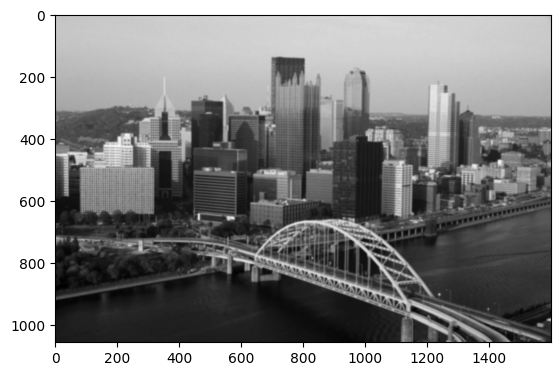

In [15]:
## test the blur:

blurred_img = cv2.filter2D(src=img, ddepth=-1, kernel=gaussian_kernel)

plt.imshow(blurred_img, cmap='gray')

### Frequency domain:

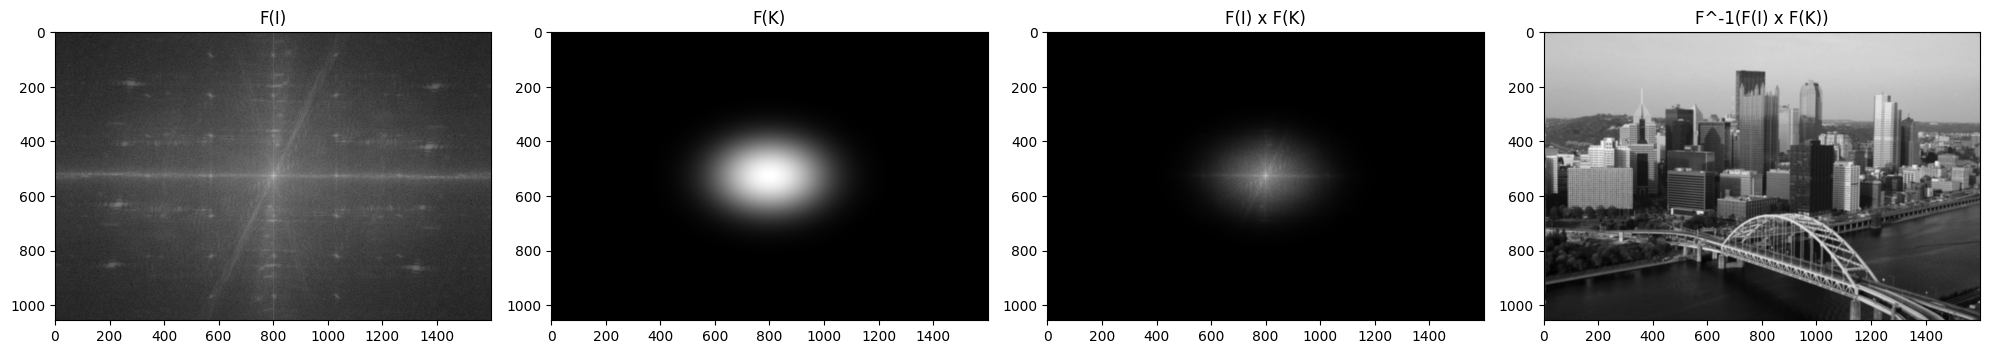

In [16]:
def get_FFTs(array):
    # returns FT of array and its magnitude for easier visualization
    base_FFT = scipy.fft.fft2(array)
    shifted_FFT = scipy.fft.fftshift(base_FFT)
    magnitude = np.log(np.abs(shifted_FFT) + 1)  # +1 to avoid log(0)

    return base_FFT, shifted_FFT, magnitude

I_ft, I_s_ft, I_s_mag = get_FFTs(img)

H,W = img.shape
K_ft = scipy.fft.fft2(gaussian_kernel, s=(H,W))
K_s_ft = scipy.fft.fftshift(K_ft)
K_s_mag = np.log(np.abs(K_s_ft)+1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

# Back to image domain:
freq_mult = I_ft * K_ft
img_conv_k = np.abs(scipy.fft.ifft2(freq_mult))

ax1.imshow(I_s_mag, cmap='gray')
ax1.set_title('F(I)')
ax2.imshow(K_s_mag, cmap='gray')
ax2.set_title('F(K)')
ax3.imshow(I_s_mag*K_s_mag, cmap='gray')
ax3.set_title('F(I) x F(K)')
ax4.imshow(img_conv_k, cmap='gray')
ax4.set_title("F^-1(F(I) x F(K))")
plt.tight_layout()

(1056, 1600)
0.9921568627450981 0.0
0.7554869203051026 0.021801051367245534


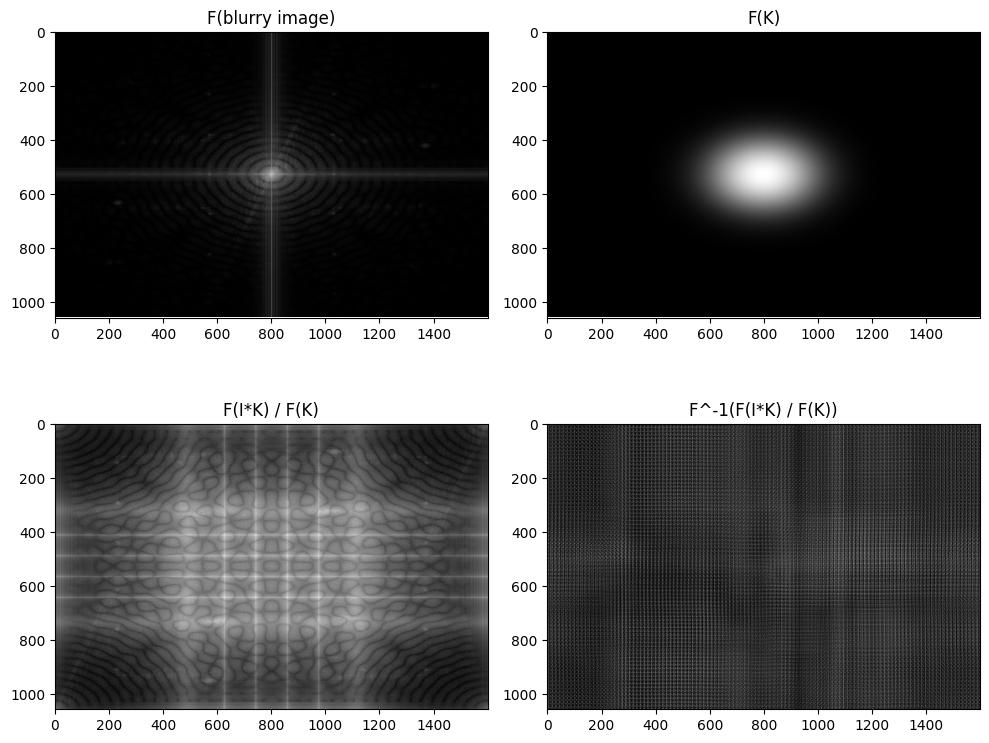

In [18]:
print(img.shape)
blurry_img = scipy.signal.convolve2d(img, circular_kernel, mode='same')
blurry_img_ft = scipy.fft.fft2(blurry_img)
print(img.max(), img.min())
print(blurry_img.max(), blurry_img.min())

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0,0].imshow(np.log(np.abs(scipy.fft.fftshift(blurry_img_ft))+1), cmap='gray')
axs[0,0].set_title("F(blurry image)")
# perfect scenario deconvolution:
I_ft_sharp = blurry_img_ft / K_ft

axs[0,1].imshow(np.log(np.abs(scipy.fft.fftshift(K_ft))+1), cmap='gray')
axs[0,1].set_title("F(K)")

axs[1,0].imshow(np.log(np.abs(I_ft_sharp)+1), cmap='gray')
axs[1,0].set_title("F(I*K) / F(K)")

I_back = scipy.fft.ifft2(I_ft_sharp)
I_back_im = np.abs(I_back)

axs[1,1].imshow(I_back_im, cmap='gray')
axs[1,1].set_title("F^-1(F(I*K) / F(K))")

plt.tight_layout()

## Bad!
#### Wiener deconvolution:


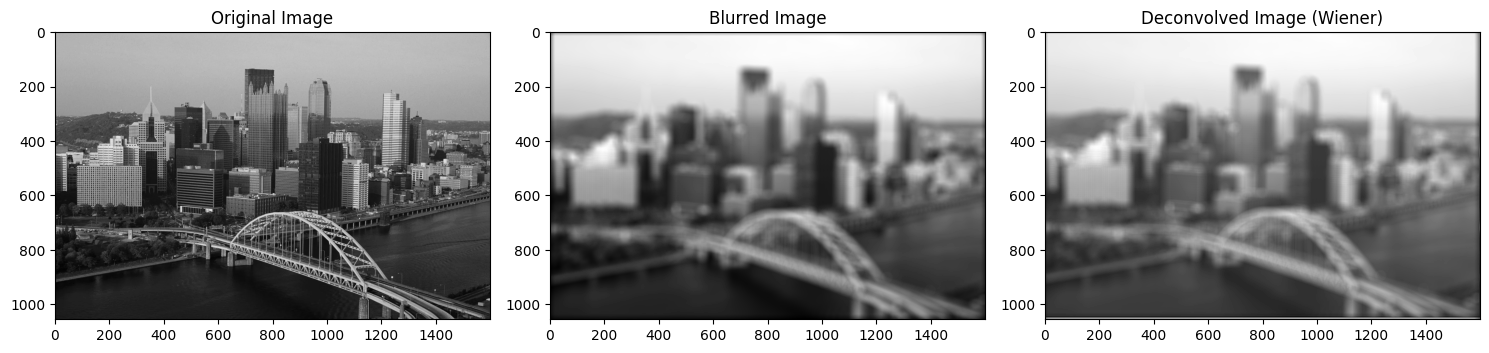

In [8]:
import numpy as np
import scipy.fft
import scipy.signal

def wiener_deconvolution(image, psf, snr=1000):
    # Compute FFTs
    image_ft = scipy.fft.fft2(image)
    psf_ft = scipy.fft.fft2(psf, s=image.shape)
    
    # Compute Wiener filter
    wiener_filter = np.conj(psf_ft) / (np.abs(psf_ft)**2 + 1/snr)
    
    # Apply filter
    deconvolved_ft = image_ft * wiener_filter
    
    # Inverse FFT and take real part
    deconvolved = np.real(scipy.fft.ifft2(deconvolved_ft))
    
    return deconvolved

import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

def wiener_deconvolution_scipy(image, psf, noise_level=0.1):
    # Pad the PSF to match the image size
    image_ft = scipy.fft.fft2(image)
    psf_ft = scipy.fft.fft2(psf, s=image.shape)
    wiener_filter = scipy.signal.wiener(image, mysize=psf.shape, noise=noise_level)
    
    # Apply Wiener filter
    deconvolved = scipy.fft.ifft(image_ft / wiener_filter)
    
    return np.abs(deconvolved)

# # Use your existing blurred image and PSF
# deconvolved_image_scipy = wiener_deconvolution_scipy(blurry_img, gaussian_kernel)

# # Visualize results
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# axs[0].imshow(img, cmap='gray')
# axs[0].set_title("Original Image")
# axs[1].imshow(blurry_img, cmap='gray')
# axs[1].set_title("Blurred Image")
# axs[2].imshow(deconvolved_image_scipy, cmap='gray')
# axs[2].set_title("Deconvolved Image (Scipy Wiener)")
# plt.tight_layout()
# plt.show()


# Use your existing blurred image and PSF
deconvolved_image = wiener_deconvolution(blurry_img, gaussian_kernel, snr=10)

# Visualize results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img, cmap='gray')
axs[0].set_title("Original Image")
axs[1].imshow(blurry_img, cmap='gray')
axs[1].set_title("Blurred Image")
axs[2].imshow(deconvolved_image, cmap='gray')
axs[2].set_title("Deconvolved Image (Wiener)")
plt.tight_layout()
plt.show()


## ADMM

(9, 12, 25, 25)
(225, 300)


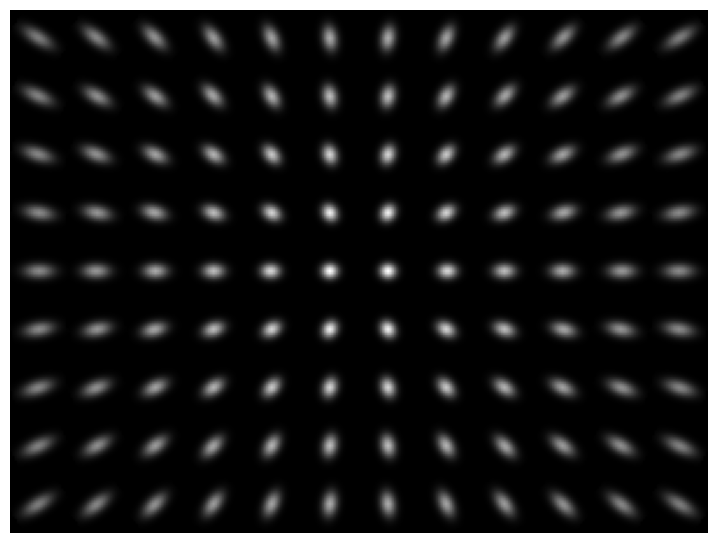

In [9]:
import numpy as np
from scipy.ndimage import rotate

def gaussian_psf(size, sigma):
    """Generate a centered Gaussian PSF
    
    Args:
        size (int): Size of the kernel (should be odd)
        sigma (float): Standard deviation of the Gaussian
        
    Returns:
        numpy.ndarray: Normalized Gaussian PSF
    """
    if size % 2 == 0:
        raise ValueError("PSF size should be odd")
        
    x = np.linspace(-(size//2), size//2, size)
    y = np.linspace(-(size//2), size//2, size)
    X, Y = np.meshgrid(x, y)
    
    # Generate 2D Gaussian
    psf = np.exp(-(X**2 + Y**2)/(2*sigma**2))
    
    # Normalize
    return psf / psf.sum()

def create_distorted_psf_grid(base_psf, image_size, grid_size):
    """Create a grid of spatially varying PSFs with radial distortion
    
    Args:
        base_psf (numpy.ndarray): Base PSF to be distorted
        image_size (tuple): Size of the image (height, width)
        grid_size (tuple): Number of PSFs in grid (rows, cols)
        
    Returns:
        numpy.ndarray: Array of PSFs with shape (rows, cols, psf_height, psf_width)
    """
    rows, cols = grid_size
    h, w = image_size
    psf_h, psf_w = base_psf.shape
    
    # Create grid centers
    x_centers = np.linspace(0, w, cols+2)[1:-1]  # exclude edges
    y_centers = np.linspace(0, h, rows+2)[1:-1]  # exclude edges
    
    # Calculate image center
    center_x = w / 2
    center_y = h / 2
    
    # Maximum distance from center (used for normalization)
    max_dist = np.sqrt(center_x**2 + center_y**2)
    
    # Initialize PSF grid
    psf_grid = np.zeros((rows, cols, psf_h, psf_w))
    
    for i, y in enumerate(y_centers):
        for j, x in enumerate(x_centers):
            # Calculate distance and angle from center
            dx = x - center_x
            dy = y - center_y
            distance = np.sqrt(dx**2 + dy**2)
            angle = -np.degrees(np.arctan2(dy, dx))
            
            # Calculate stretch factor based on distance from center
            stretch_factor = 1 + (distance / max_dist) * 1.5
            
            # Create stretched PSF
            stretched_psf = np.copy(base_psf)
            # Apply anisotropic scaling - stretch more in radial direction
            new_width = int(psf_w * stretch_factor)
            temp_psf = cv2.resize(stretched_psf, (new_width, psf_h), 
                                interpolation=cv2.INTER_LINEAR)
            
            # Crop/pad to maintain original size
            if new_width > psf_w:
                start = (new_width - psf_w) // 2
                temp_psf = temp_psf[:, start:start+psf_w]
            else:
                pad_width = (psf_w - new_width) // 2
                temp_psf = np.pad(temp_psf, ((0,0), (pad_width, pad_width)), 
                                mode='constant')
            
            # Rotate the PSF to point radially outward from center
            rotated_psf = rotate(temp_psf, angle, reshape=False)
            
            # Normalize
            rotated_psf = rotated_psf / rotated_psf.sum()
            
            # Store in grid
            psf_grid[i, j] = rotated_psf
            
    return psf_grid


# Create base Gaussian PSF
base_psf = gaussian_psf(25, 2.2)

# Create grid of distorted PSFs
image_size = (H, W)  # Example image size
grid_size = (9, 12)      # 4x4 grid of PSFs
psf_grid = create_distorted_psf_grid(base_psf, image_size, grid_size)
print(psf_grid.shape)
# Visualization code
import matplotlib.pyplot as plt

# Create a single image by concatenating all PSFs
psf_h, psf_w = psf_grid[0,0].shape
full_image = np.zeros((grid_size[0]*psf_h, grid_size[1]*psf_w))

for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        y_start = i * psf_h
        x_start = j * psf_w
        full_image[y_start:y_start+psf_h, x_start:x_start+psf_w] = psf_grid[i,j]
print(full_image.shape)
plt.figure(figsize=(9, 12))
plt.imshow(full_image, cmap='gray')
plt.axis('off')
plt.show()

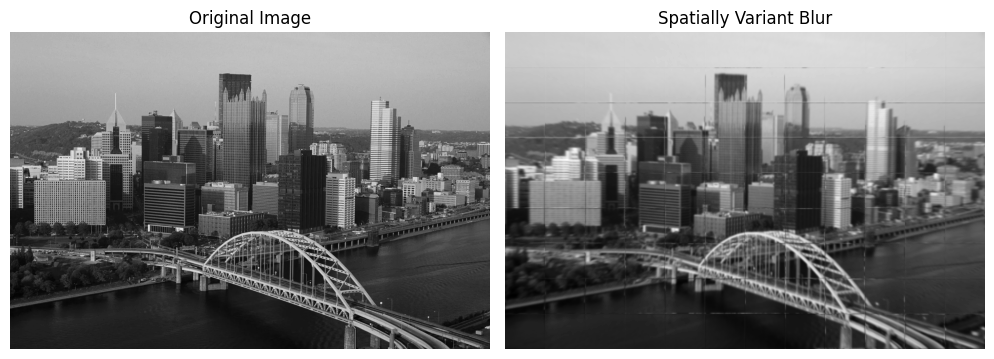

In [10]:
def spatially_variant_blur(img, psf_grid):
    # Get dimensions
    grid_h, grid_w = psf_grid.shape[:2]
    psf_h, psf_w = psf_grid[0,0].shape
    
    # Calculate patch sizes
    img_h, img_w = img.shape
    patch_h = img_h // grid_h
    patch_w = img_w // grid_w
    
    # Crop image to fit grid exactly
    img = img[:patch_h*grid_h, :patch_w*grid_w]
    
    # Initialize output image
    blurred = np.zeros_like(img)
    
    # Process each patch
    for i in range(grid_h):
        for j in range(grid_w):
            # Extract patch
            y_start = i * patch_h
            x_start = j * patch_w
            patch = img[y_start:y_start+patch_h, x_start:x_start+patch_w]
            
            # Convolve with corresponding PSF
            blurred_patch = scipy.signal.convolve2d(patch, psf_grid[i,j], mode='same', boundary='wrap')
            
            # Place back in output image
            blurred[y_start:y_start+patch_h, x_start:x_start+patch_w] = blurred_patch
            
    return blurred

# Example usage:
# Load or create a test image
test_img = np.zeros((900, 1200))  # Example size matching grid ratio
test_img[400:500, 500:700] = 1  # Create a simple white rectangle

# Apply spatially-variant blur
blurred_img = spatially_variant_blur(img, psf_grid)

# Visualize results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(blurred_img, cmap='gray')
plt.title('Spatially Variant Blur')
plt.axis('off')


plt.tight_layout()
plt.show()


In [11]:
import numpy as np
from scipy.fft import fft2, ifft2
import matplotlib.pyplot as plt
from tqdm import tqdm

class TVDeblurVariableBlur:
    def __init__(self, params):
        """
        Initialize deblurring solver with parameters
        
        params: dict containing:
            - max_iter: maximum iterations
            - t: step size
            - beta: scaling parameter
            - gamma: regularization parameter
            - over_relax: over-relaxation parameter
            - show_trigger: visualization frequency
        """
        self.params = params
        self.costs = []
        self.errors = []

    def setup_operators(self, b, kernels, U):
        """Setup all operators and initial variables"""
        self.num_rows, self.num_cols, self.num_kernels = U.shape
        self.d = (kernels.shape[0] - 1) // 2
        
        # Scale parameters
        self.kernels = self.params['beta'] * kernels
        self.b = self.params['beta'] * b
        self.gamma = self.params['beta'] * self.params['gamma']
        
        # Setup gradient operators
        self.setup_gradient_operators()
        
        # Setup convolution operators
        self.setup_convolution_operators()
        
        # Setup weights
        self.setup_weights(U)
        
        # Initialize variables
        self.initialize_variables()

    def setup_gradient_operators(self):
        """Setup gradient operators and their eigenvalues"""
        beta = self.params['beta']
        
        # Create derivative kernels
        D1 = beta * np.array([-1, 1]).reshape(-1, 1)  # Vertical
        D2 = beta * np.array([-1, 1]).reshape(1, -1)  # Horizontal
        
        # Get eigenvalues for FFT-based operations
        self.eig_val_D1 = self.get_eig_val_arr_for_cyclic_conv(
            D1, 
            self.num_rows + 2*self.d, 
            self.num_cols + 2*self.d
        )
        self.eig_val_D2 = self.get_eig_val_arr_for_cyclic_conv(
            D2, 
            self.num_rows + 2*self.d, 
            self.num_cols + 2*self.d
        )
        
        self.eig_val_D1_trans = np.conj(self.eig_val_D1)
        self.eig_val_D2_trans = np.conj(self.eig_val_D2)

    def setup_convolution_operators(self):
        """Setup convolution operators for each kernel"""
        shape = (self.num_rows + 2*self.d, self.num_cols + 2*self.d, self.num_kernels)
        self.eig_val_arrs_Kp = np.zeros(shape, dtype=complex)
        self.eig_val_arrs_Kp_trans = np.zeros(shape, dtype=complex)
        
        for k in range(self.num_kernels):
            eig_val = self.get_eig_val_arr_for_cyclic_conv(
                self.kernels[:,:,k],
                self.num_rows + 2*self.d,
                self.num_cols + 2*self.d
            )
            self.eig_val_arrs_Kp[:,:,k] = eig_val
            self.eig_val_arrs_Kp_trans[:,:,k] = np.conj(eig_val)

    def setup_weights(self, U):
        """Setup weight matrices"""
        self.U = U
        self.Lambda = 1.0 / np.sum(U**2, axis=2)
        
        self.v = np.zeros_like(U)
        for k in range(self.num_kernels):
            self.v[:,:,k] = U[:,:,k] * self.Lambda
        
        self.v_norm_squared = np.sum(self.v**2, axis=2)

    def initialize_variables(self):
        """Initialize optimization variables"""
        # Setup matrix for linear system
        self.setup_linear_system_matrix()
        
        # Initialize primal and dual variables
        shape_x = (self.num_rows + 2*self.d, self.num_cols + 2*self.d)
        shape_z1 = (self.num_rows + 2*self.d, self.num_cols + 2*self.d, self.num_kernels)
        shape_z2 = (self.num_rows + 2*self.d, self.num_cols + 2*self.d, 2)  # For D1, D2
        
        self.z_x = np.zeros(shape_x)
        self.z_x[self.d:self.d + self.num_rows, 
                self.d:self.d + self.num_cols] = self.b / self.params['beta']
        
        self.z_z1 = np.zeros(shape_z1)
        self.z_z2 = np.zeros(shape_z2)

    def setup_linear_system_matrix(self):
        """Setup matrix for linear system solution"""
        t = self.params['t']
        
        # Build matrix I + t^2 A^T A
        self.eig_vals_mtrx = np.zeros((self.num_rows + 2*self.d, 
                                     self.num_cols + 2*self.d),
                                     dtype=complex)
        
        # Add kernel terms
        for k in range(self.num_kernels):
            self.eig_vals_mtrx += (self.eig_val_arrs_Kp_trans[:,:,k] * 
                                  self.eig_val_arrs_Kp[:,:,k])
        
        # Add gradient terms
        self.eig_vals_mtrx += (self.eig_val_D1_trans * self.eig_val_D1 + 
                              self.eig_val_D2_trans * self.eig_val_D2)
        
        self.eig_vals_mtrx = (t**2) * self.eig_vals_mtrx + 1

    @staticmethod
    def get_eig_val_arr_for_cyclic_conv(kernel, num_rows, num_cols):
        """Compute eigenvalues for cyclic convolution"""
        padded_kernel = np.zeros((num_rows, num_cols))
        kr, kc = kernel.shape
        padded_kernel[:kr, :kc] = kernel
        return fft2(np.roll(np.roll(padded_kernel, -kr//2, axis=0), -kc//2, axis=1))

    def apply_cyclic_conv_2d(self, x, eig_val_arr):
        """Apply cyclic convolution using FFT"""
        return np.real(ifft2(fft2(x) * eig_val_arr))

    def apply_D(self, x):
        """Apply gradient operator"""
        D1x = self.apply_cyclic_conv_2d(x, self.eig_val_D1)
        D2x = self.apply_cyclic_conv_2d(x, self.eig_val_D2)
        return np.stack([D1x, D2x], axis=2)

    def apply_D_trans(self, y):
        """Apply transpose of gradient operator"""
        return (self.apply_cyclic_conv_2d(y[:,:,0], self.eig_val_D1_trans) + 
                self.apply_cyclic_conv_2d(y[:,:,1], self.eig_val_D2_trans))

    def eval_iso_norm(self, y):
        """Evaluate isotropic norm"""
        return np.sum(np.sqrt(y[:,:,0]**2 + y[:,:,1]**2))

    def prox_g1_star(self, z_z1):
        """Proximal operator for data fidelity term"""
        t = self.params['t']
        y_hat = z_z1 / t
        
        # Compute U * y_hat
        U_y_hat = np.zeros((self.num_rows, self.num_cols))
        for k in range(self.num_kernels):
            U_y_hat += (self.U[:,:,k] * 
                       y_hat[self.d:self.d+self.num_rows,
                            self.d:self.d+self.num_cols,k])
        
        Lambda_U_y_hat = self.Lambda * U_y_hat
        w = np.zeros_like(self.U)
        for k in range(self.num_kernels):
            w[:,:,k] = self.U[:,:,k] * Lambda_U_y_hat
        
        term = np.sum(self.v * w, axis=2) / self.v_norm_squared
        
        tau = 1.0 / (t * self.v_norm_squared)
        tmp = (tau * self.b + term) / (tau + 1)
        vec = self.Lambda * (tmp - U_y_hat)
        
        prox_g1 = np.zeros_like(z_z1)
        for k in range(self.num_kernels):
            prox_g1[self.d:self.d+self.num_rows,
                   self.d:self.d+self.num_cols,k] = self.U[:,:,k] * vec
        
        prox_g1 = y_hat + prox_g1
        return z_z1 - t * prox_g1

    def prox_g2_star(self, z_z2):
        """Proximal operator for TV term"""
        norm = np.sqrt(np.sum(z_z2**2, axis=2))
        scale = np.minimum(1, 1/norm)
        return self.gamma * (z_z2 * scale[:,:,np.newaxis])

    def solve(self, b, kernels, U, x_star=None):
        """Main solving routine"""
        self.setup_operators(b, kernels, U)
        
        for iter in tqdm(range(self.params['max_iter'])):
            # Update primal variable
            x_plus_x = self.z_x.copy()
            
            # Update dual variables
            x_plus_z1 = self.prox_g1_star(self.z_z1)
            x_plus_z2 = self.prox_g2_star(self.z_z2)
            
            # Compute intermediate terms
            term_x = 2*x_plus_x - self.z_x
            term_z1 = 2*x_plus_z1 - self.z_z1
            term_z2 = 2*x_plus_z2 - self.z_z2
            
            # Update y variables
            self.update_y_variables(term_x, term_z1, term_z2)
            
            # Update z variables
            self.update_z_variables(x_plus_x, x_plus_z1, x_plus_z2)
            
            # Compute cost and error
            self.compute_metrics(x_plus_x, x_star)
            
            # Visualize if needed
            # self.visualize(iter, x_plus_x)
            # Save current reconstruction for visualization
            import os
            save_dir = '../results/dr-astronaut'
            os.makedirs(save_dir, exist_ok=True)
            np.save(os.path.join(save_dir, f'{iter:04d}.npy'), x_plus_x)
        
        return x_plus_x, self.costs, self.errors

    def update_y_variables(self, term_x, term_z1, term_z2):
        """Update y variables"""
        t = self.params['t']
        
        # Compute A^T term_z
        A_trans_term_z = np.zeros_like(term_x)
        for k in range(self.num_kernels):
            A_trans_term_z += self.apply_cyclic_conv_2d(
                term_z1[:,:,k],
                self.eig_val_arrs_Kp_trans[:,:,k]
            )
        A_trans_term_z += self.apply_D_trans(term_z2)
        
        # Solve linear system
        rhs = term_x - t * A_trans_term_z
        self.y_plus_x = np.real(ifft2(fft2(rhs) / self.eig_vals_mtrx))
        
        # Update y_plus_z1
        self.y_plus_z1 = np.zeros_like(self.z_z1)
        for k in range(self.num_kernels):
            self.y_plus_z1[:,:,k] = self.apply_cyclic_conv_2d(
                self.y_plus_x,
                self.eig_val_arrs_Kp[:,:,k]
            )
        self.y_plus_z1 = term_z1 + t * self.y_plus_z1
        
        # Update y_plus_z2
        self.y_plus_z2 = term_z2 + t * self.apply_D(self.y_plus_x)

    def update_z_variables(self, x_plus_x, x_plus_z1, x_plus_z2):
        """Update z variables"""
        over_relax = self.params['over_relax']
        
        self.z_x = self.z_x + over_relax * (self.y_plus_x - x_plus_x)
        self.z_z1 = self.z_z1 + over_relax * (self.y_plus_z1 - x_plus_z1)
        self.z_z2 = self.z_z2 + over_relax * (self.y_plus_z2 - x_plus_z2)

    def compute_metrics(self, x_plus_x, x_star):
        """Compute cost and error metrics"""
        # Compute Kx
        Kx = np.zeros((self.num_rows, self.num_cols))
        for k in range(self.num_kernels):
            Kpx = self.apply_cyclic_conv_2d(
                x_plus_x,
                self.eig_val_arrs_Kp[:,:,k]
            )
            Kx += (self.U[:,:,k] * 
                  Kpx[self.d:self.d+self.num_rows,
                      self.d:self.d+self.num_cols])
        
        # Compute Dx
        Dx = self.apply_D(x_plus_x)
        
        # Compute cost
        cost = (0.5 * np.sum((Kx - self.b)**2) + 
                self.gamma * self.eval_iso_norm(Dx))
        cost = cost / self.params['beta']**2
        self.costs.append(cost)
        
        # Compute error if x_star is provided
        if x_star is not None:
            error = np.linalg.norm((x_plus_x - x_star).flatten())
            self.errors.append(error)

    def visualize(self, iter, x_plus_x):
        """Visualize current solution"""
        if iter % self.params['show_trigger'] == 0:
            if iter == self.params['show_trigger']:
                plt.figure(figsize=(10, 10))
            
            reduced = x_plus_x[self.d:self.d + self.num_rows,
                             self.d:self.d + self.num_cols]
            plt.imshow(reduced, cmap='gray')
            plt.title(f'Iteration {iter}')
            plt.pause(0.1)

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/l4/t_19h62x50q9r_p9gfjtch600000gn/T/ipykernel_50353/790128735.py:192: RuntimeWarning: divide by zero encountered in divide
  scale = np.minimum(1, 1/norm)
100%|██████████| 100/100 [10:19<00:00,  6.20s/it]


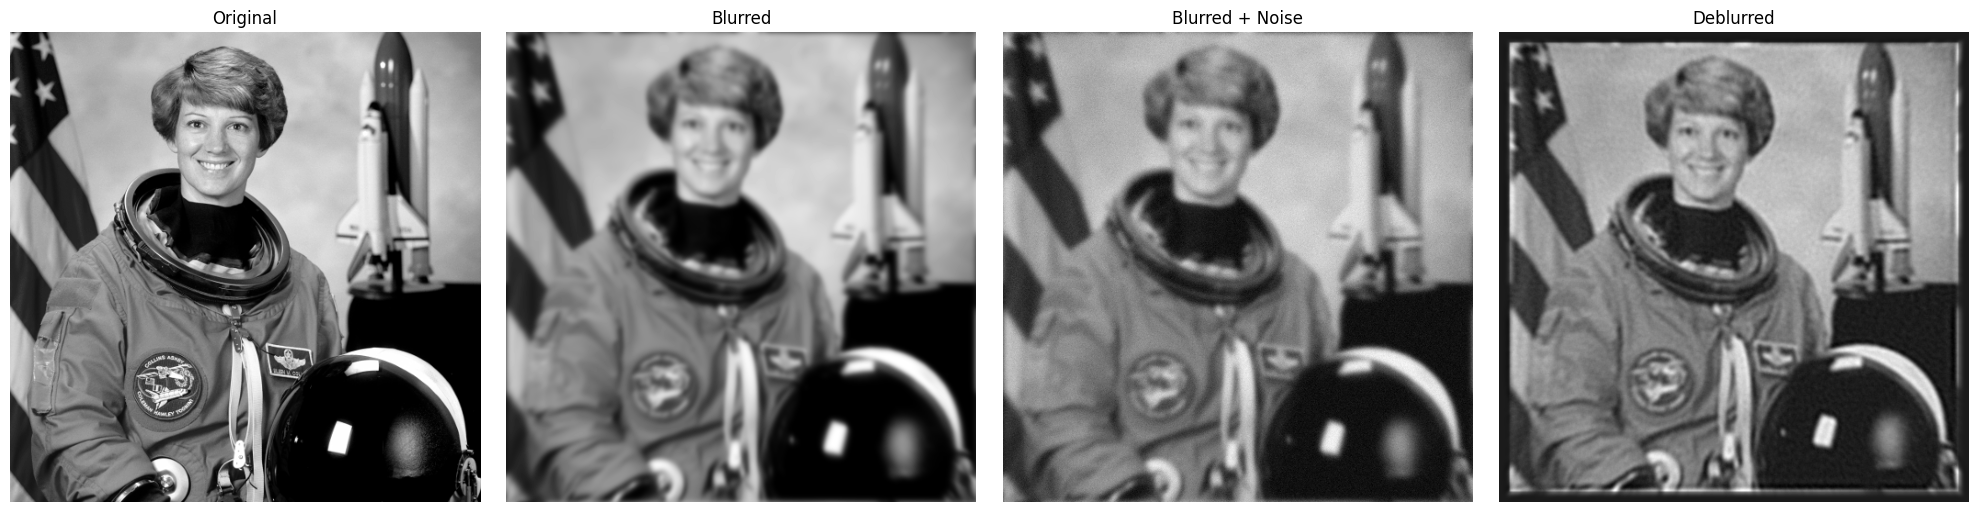

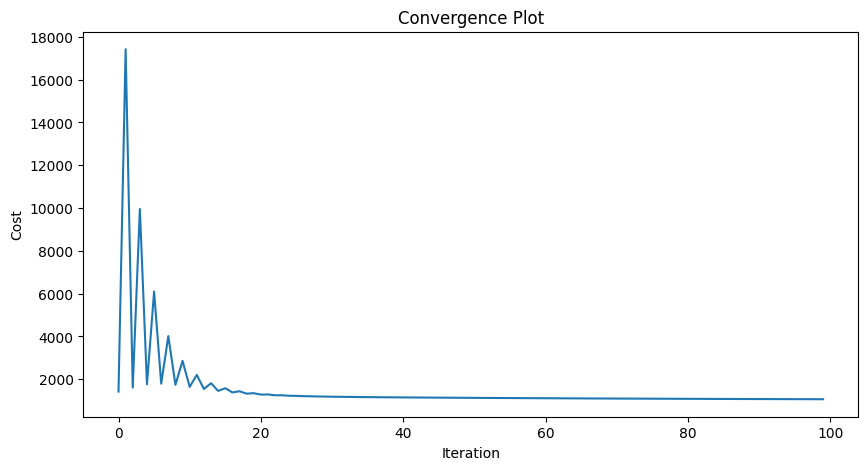

In [12]:
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage import data, color
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

def create_gaussian_psf(size, sigma):
    """Create a Gaussian PSF"""
    psf = np.zeros((size, size))
    center = size // 2
    psf[center, center] = 1
    return gaussian_filter(psf, sigma)

def create_spatially_varying_psfs(image_size, grid_size=3, psf_size=15):
    """
    Create spatially varying gaussian PSFs on a grid using radial distortion
    
    """
    # Create base PSF
    base_psf = gaussian_psf(psf_size, 2.0)
    
    # Create grid of distorted PSFs
    psf_grid = create_distorted_psf_grid(base_psf, image_size, (grid_size, grid_size))
    
    # Reshape PSF grid to match expected format
    kernels = np.zeros((psf_size, psf_size, grid_size**2))
    U = np.zeros((*image_size, grid_size**2))
    
    # Create grid points for weights
    x = np.linspace(-1, 1, grid_size)
    y = np.linspace(-1, 1, grid_size)
    xx, yy = np.meshgrid(x, y)
    
    # Transfer PSFs to kernels array
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            kernels[:,:,idx] = psf_grid[i,j]
    
    # Create weights (U) using radial basis functions
    img_y = np.linspace(-1, 1, image_size[0])
    img_x = np.linspace(-1, 1, image_size[1])
    img_xx, img_yy = np.meshgrid(img_x, img_y)
    
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            # Calculate distance from current grid point to all image points
            dist = np.sqrt((img_xx - xx[i,j])**2 + (img_yy - yy[i,j])**2)
            # Create weight using RBF
            U[:,:,idx] = np.exp(-5 * dist**2)  # Adjust the -5 to control weight falloff
    
    # Normalize weights so they sum to 1 at each pixel
    U_sum = U.sum(axis=2, keepdims=True)
    U = U / U_sum
    
    return kernels, U

def apply_spatially_varying_blur(image, kernels, U):
    """Apply spatially varying blur to image"""
    blurred = np.zeros_like(image)
    
    for i in range(kernels.shape[2]):
        # Convolve with current kernel
        temp = convolve2d(image, kernels[:,:,i], mode='same', boundary='wrap')
        # Apply weights
        blurred += temp * U[:,:,i]
    
    return blurred


# Load and prepare image
img = color.rgb2gray(data.astronaut())

# Create PSFs and weights
grid_size = 9
psf_size = 25
kernels, U = create_spatially_varying_psfs(img.shape, grid_size, psf_size)

# Apply blur
blurred = apply_spatially_varying_blur(img, kernels, U)

# Add noise
noise_level = 0.02
noisy_blurred = blurred + noise_level * np.random.randn(*blurred.shape)

# Setup solver parameters
params = {
    'max_iter': 100,
    't': 0.1,
    'beta': 1.0,
    'gamma': 0.1,
    'over_relax': 1.8,
    'show_trigger': 50
}
    
# Initialize and run solver
solver = TVDeblurVariableBlur(params)
deblurred, costs, errors = solver.solve(noisy_blurred, kernels, U)

# Visualize results
plt.figure(figsize=(20, 5))

plt.subplot(141)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(142)
plt.imshow(blurred, cmap='gray')
plt.title('Blurred')
plt.axis('off')

plt.subplot(143)
plt.imshow(noisy_blurred, cmap='gray')
plt.title('Blurred + Noise')
plt.axis('off')

plt.subplot(144)
plt.imshow(deblurred, cmap='gray')
plt.title('Deblurred')
plt.axis('off')

plt.tight_layout()
plt.show()

# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(costs)
plt.title('Convergence Plot')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()


In [10]:
base_psf = get_gaussian_psf(img, 15, std=2.2)

# Create grid of distorted PSFs
# image_size = (H, W)  # Example image size
grid_size = (5, 5)      # 4x4 grid of PSFs
psf_grid = create_distorted_psf_grid(base_psf, image_size, grid_size)
print(psf_grid.shape)
# Visualization code
import matplotlib.pyplot as plt

# Create a single image by concatenating all PSFs
psf_h, psf_w = psf_grid[0,0].shape
full_image = np.zeros((grid_size[0]*psf_h, grid_size[1]*psf_w))

for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        y_start = i * psf_h
        x_start = j * psf_w
        full_image[y_start:y_start+psf_h, x_start:x_start+psf_w] = psf_grid[i,j]
print(full_image.shape)
plt.figure(figsize=(9, 12))
plt.imshow(full_image, cmap='gray')
plt.axis('off')
plt.show()


NameError: name 'H' is not defined

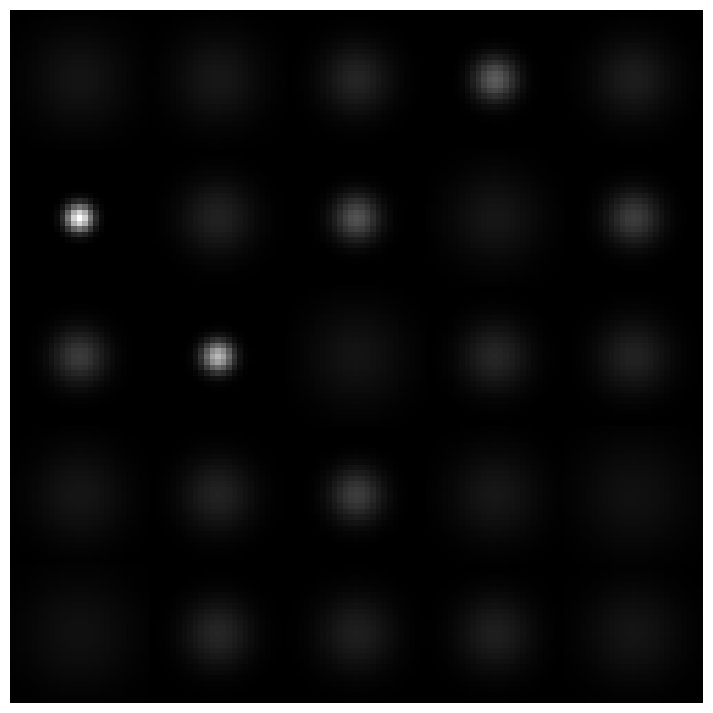

In [14]:
# Create a grid of Gaussian PSFs with random standard deviations
grid_size = (5, 5)  # 5x5 grid
psf_size = 25  # Each PSF is 25x25 pixels

# Generate random standard deviations between 1.0 and 4.0
std_devs = np.random.uniform(1.0, 7.0, size=grid_size)

# Create grid of PSFs
psf_grid = np.zeros((grid_size[0], grid_size[1], psf_size, psf_size))
for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        psf_grid[i,j] = gaussian_psf(psf_size, std_devs[i,j])

# Visualize the grid
psf_h, psf_w = psf_grid[0,0].shape
full_image = np.zeros((grid_size[0]*psf_h, grid_size[1]*psf_w))

for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        y_start = i * psf_h
        x_start = j * psf_w
        full_image[y_start:y_start+psf_h, x_start:x_start+psf_w] = psf_grid[i,j]

plt.figure(figsize=(9, 9))
plt.imshow(full_image, cmap='gray')
plt.axis('off')
plt.show()


# NEW VERSION DR

In [67]:
import numpy as np
from scipy import fft
import tqdm

class DRDeblur:
    """
    Implements spatially-variant deblurring using Douglas-Rachford splitting with TV regularization.
    Uses the Nagy-O'Leary model for spatially variant blur: K = sum(Up*Kp).
    """
    def __init__(self, img, psfs, weights, gamma=0.1, t=1.0, rho=1.8, log=False):
        self.img = img
        self.psfs = psfs
        self.weights = weights
        self.gamma = gamma  # TV regularization strength
        self.t = t         # Step size
        self.rho = rho     # Relaxation parameter
        self.log = log
        self.H, self.W = img.shape
        self.pad = (psfs[0].shape[0] - 1) // 2  # Padding size
        self.n_kernels = len(psfs)
        self.precompute_operators()


    def precompute_operators(self):
        """Precompute FFT operators for efficiency"""
        padded_shape = (self.H + 2*self.pad, self.W + 2*self.pad)
        
        # FFT of PSFs
        self.psf_fts = []
        for psf in self.psfs:
            psf_ft = fft.fft2(psf, s=padded_shape)
            self.psf_fts.append(psf_ft)

        # FFT of gradient operators
        grad_x = np.array([[-1, 1]])          # Horizontal gradient
        grad_y = np.array([[-1], [1]])        # Vertical gradient
        self.grad_x_ft = fft.fft2(grad_x, s=padded_shape)
        self.grad_y_ft = fft.fft2(grad_y, s=padded_shape)

        # Precompute denominator for linear system
        self.setup_linear_system()


    def apply_blur(self, x):
        """Apply spatially variant blur K = sum(Up*Kp)"""
        # For single image input
        if x.ndim == 2:
            x_ft = fft.fft2(x)
            result = np.zeros_like(x)
            for k in range(self.n_kernels):
                # Apply each PSF
                # print("psf shape",self.psf_fts[k].shape)
                conv_k = np.real(fft.ifft2(x_ft * self.psf_fts[k]))
                # print("conv k shape", conv_k.shape)
                # Weight the result
                # print("weights shape", self.weights[...,k].shape)
                # Pad weights with zeros to match convolution output size
                padded_weights = np.pad(self.weights[...,k], pad_width=self.pad, mode='constant', constant_values=0)
                # result += self.weights[..., k] * conv_k
                result += padded_weights * conv_k
            return result
        
        # For multi-channel input (term_z1)
        elif x.ndim == 3:
            result = np.zeros_like(x[..., 0])  # Output is 2D
            for k in range(self.n_kernels):
                # Take kth channel
                conv_k = np.real(fft.ifft2(fft.fft2(x[..., k]) * self.psf_fts[k]))
                result += self.weights[..., k] * conv_k
            return result

    def apply_gradients(self, x):
        """Compute horizontal and vertical gradients"""
        x_ft = fft.fft2(x)
        dx = np.real(fft.ifft2(self.grad_x_ft * x_ft))
        dy = np.real(fft.ifft2(self.grad_y_ft * x_ft))
        return dx, dy

    def prox_data_fidelity(self, z, t):
        """Proximal operator for data fidelity term"""
        # Split z into weighted sum
        z_center = z[self.pad:-self.pad, self.pad:-self.pad]
        weighted_sum = np.zeros_like(self.img)
        for k in range(self.n_kernels):
            weighted_sum += self.weights[..., k] * z_center[..., k]
        
        # Compute proximal step
        factor = 1.0 / (1.0 + t)
        prox = weighted_sum - factor * (weighted_sum - self.img)
        
        # Build padded result
        result = z.copy()
        for k in range(self.n_kernels):
            result[self.pad:-self.pad, self.pad:-self.pad, k] = \
                self.weights[..., k] * prox
        return result

    
    def prox_tv(self, v):
        return np.maximum(0, v - self.gamma) - np.maximum(0, -v - self.gamma)

    def setup_linear_system(self):
        """Precompute denominator for FFT-based linear system solve"""
        denom = np.ones((self.H + 2*self.pad, self.W + 2*self.pad), dtype=complex)
        
        # Add PSF terms
        for psf_ft in self.psf_fts:
            denom += (self.t**2) * (np.conj(psf_ft) * psf_ft)
        
        # Add gradient terms
        denom += (self.t**2) * (
            np.conj(self.grad_x_ft) * self.grad_x_ft + 
            np.conj(self.grad_y_ft) * self.grad_y_ft
        )
    
        self.system_denom = denom

    def solve_linear_system(self, term_x, term_z1, term_z2):
        """Solve linear system using FFT"""
        # Compute A^T term_z
        A_trans_term_z = np.zeros_like(term_x)
        
        # Handle PSF terms
        for k in range(self.n_kernels):
            A_trans_term_z += np.real(ifft2(
                fft2(term_z1[:,:,k]) * np.conj(self.psf_fts[k])
            ))
        
        # Handle gradient terms
        grad_term = np.real(ifft2(
            fft2(term_z2[:,:,0]) * np.conj(self.grad_x_ft) +
            fft2(term_z2[:,:,1]) * np.conj(self.grad_y_ft)
        ))
        A_trans_term_z += grad_term
        
        # Solve system
        rhs = term_x - self.t * A_trans_term_z
        return np.real(ifft2(fft2(rhs) / self.system_denom))
    
    def solve(self, n_iters):
        """Main Douglas-Rachford iteration"""
        # Initialize variables
        shape_x = (self.H + 2*self.pad, self.W + 2*self.pad)
        shape_z1 = shape_x + (self.n_kernels,)
        shape_z2 = shape_x + (2,)  # For gradients
        
        x = np.zeros(shape_x)
        z1 = np.zeros(shape_z1)  # For blur terms
        z2 = np.zeros(shape_z2)  # For gradient terms
        
        # Dual variables
        p = np.zeros(shape_x)     # For image
        q1 = np.zeros(shape_z1)   # For blur terms
        q2 = np.zeros(shape_z2)   # For gradient terms

        if self.log:
            self.losses = {'total': []}
            self.xs = []

        for _ in tqdm.tqdm(range(n_iters)):
            # Primal updates
            x_new = p
            z1_new = self.prox_data_fidelity(q1, self.t)
            z2_new = self.prox_tv(q2)
            
            # Compute intermediate terms
            term_x = 2*x_new - p
            term_z1 = 2*z1_new - q1
            term_z2 = 2*z2_new - q2
            
            # Linear system solve
            y_x = self.solve_linear_system(term_x, term_z1, term_z2)
            
            # Initialize y_z1 with correct shape
            y_z1 = np.zeros(shape_z1)
            
            # Update auxiliary variables
            for k in range(self.n_kernels):
                blurred = np.real(fft.ifft2(fft.fft2(y_x) * self.psf_fts[k]))
                y_z1[..., k] = term_z1[..., k] + self.t * blurred
            
            dx, dy = self.apply_gradients(y_x)
            y_z2 = term_z2 + self.t * np.stack([dx, dy], axis=-1)
            
            # Update dual variables
            p = p + self.rho * (y_x - x_new)
            q1 = q1 + self.rho * (y_z1 - z1_new)
            q2 = q2 + self.rho * (y_z2 - z2_new)

            if self.log:
                self.compute_loss(x_new)
                self.xs.append(x_new)

        # Return unpadded result
        return x_new[self.pad:-self.pad, self.pad:-self.pad]

    def compute_loss(self, x):
        """Compute total loss"""
        # Extract unpadded region
        # print('xloss shape', x.shape)
        x_center = x[self.pad:-self.pad, self.pad:-self.pad]
        
        # Data fidelity term
        blur = self.apply_blur(x)
        blur_center = blur[self.pad:-self.pad, self.pad:-self.pad]
        fidelity = 0.5 * np.sum((blur_center - self.img)**2)
        
        # TV term (L1 norm of gradients)
        dx, dy = self.apply_gradients(x)
        dx_center = dx[self.pad:-self.pad, self.pad:-self.pad]
        dy_center = dy[self.pad:-self.pad, self.pad:-self.pad]
        tv = self.gamma * (np.sum(np.abs(dx_center)) + np.sum(np.abs(dy_center)))
        
        self.losses['total'].append(fidelity + tv)

In [65]:
img = color.rgb2gray(data.astronaut())

# Create PSFs and weights
grid_size = 5
psf_size = 25
kernels, U = create_spatially_varying_psfs(img.shape, grid_size, psf_size)

# Apply blur
blurred = apply_spatially_varying_blur(img, kernels, U)

# Add noise
noise_level = 0.02
noisy_blurred = blurred + noise_level * np.random.randn(*blurred.shape)

# Setup solver parameters
params = {
    'max_iter': 100,
    't': 0.1,
    'beta': 1.0,
    'gamma': 0.1,
    'over_relax': 1.8,
    'show_trigger': 50
}

solver = DRDeblur(noisy_blurred, kernels, U, gamma=0.1, t=1.0, rho=1.8, log=True)

In [66]:
deblurred = solver.solve(n_iters = 50)

  0%|          | 0/50 [00:00<?, ?it/s]

xloss shape (536, 536)


  2%|▏         | 1/50 [00:01<01:23,  1.70s/it]

xloss shape (536, 536)


  4%|▍         | 2/50 [00:02<01:09,  1.45s/it]

xloss shape (536, 536)


  6%|▌         | 3/50 [00:04<01:02,  1.32s/it]

xloss shape (536, 536)


  8%|▊         | 4/50 [00:05<01:03,  1.38s/it]

xloss shape (536, 536)


 10%|█         | 5/50 [00:06<00:59,  1.31s/it]

xloss shape (536, 536)


 12%|█▏        | 6/50 [00:08<01:01,  1.40s/it]

xloss shape (536, 536)


 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]

xloss shape (536, 536)


 16%|█▌        | 8/50 [00:10<00:55,  1.32s/it]

xloss shape (536, 536)


 18%|█▊        | 9/50 [00:12<00:57,  1.39s/it]

xloss shape (536, 536)


 20%|██        | 10/50 [00:13<00:52,  1.32s/it]

xloss shape (536, 536)


 22%|██▏       | 11/50 [00:15<00:53,  1.37s/it]

xloss shape (536, 536)


 24%|██▍       | 12/50 [00:16<00:50,  1.33s/it]

xloss shape (536, 536)


 26%|██▌       | 13/50 [00:17<00:47,  1.29s/it]

xloss shape (536, 536)


 28%|██▊       | 14/50 [00:19<00:49,  1.36s/it]

xloss shape (536, 536)


 30%|███       | 15/50 [00:20<00:46,  1.34s/it]

xloss shape (536, 536)


 32%|███▏      | 16/50 [00:21<00:47,  1.40s/it]

xloss shape (536, 536)


 34%|███▍      | 17/50 [00:23<00:44,  1.35s/it]

xloss shape (536, 536)


 36%|███▌      | 18/50 [00:24<00:41,  1.30s/it]

xloss shape (536, 536)


 38%|███▊      | 19/50 [00:25<00:41,  1.34s/it]

xloss shape (536, 536)


 40%|████      | 20/50 [00:26<00:38,  1.28s/it]

xloss shape (536, 536)


 42%|████▏     | 21/50 [00:28<00:37,  1.28s/it]

xloss shape (536, 536)


 44%|████▍     | 22/50 [00:29<00:37,  1.36s/it]

xloss shape (536, 536)


 46%|████▌     | 23/50 [00:30<00:35,  1.30s/it]

xloss shape (536, 536)


 48%|████▊     | 24/50 [00:32<00:33,  1.27s/it]

xloss shape (536, 536)


 50%|█████     | 25/50 [00:33<00:33,  1.33s/it]

xloss shape (536, 536)


 52%|█████▏    | 26/50 [00:34<00:30,  1.29s/it]

xloss shape (536, 536)


 54%|█████▍    | 27/50 [00:35<00:28,  1.26s/it]

xloss shape (536, 536)


 56%|█████▌    | 28/50 [00:37<00:29,  1.32s/it]

xloss shape (536, 536)


 58%|█████▊    | 29/50 [00:38<00:26,  1.28s/it]

xloss shape (536, 536)


 60%|██████    | 30/50 [00:39<00:26,  1.33s/it]

xloss shape (536, 536)


 62%|██████▏   | 31/50 [00:41<00:24,  1.29s/it]

xloss shape (536, 536)


 64%|██████▍   | 32/50 [00:42<00:24,  1.34s/it]

xloss shape (536, 536)


 66%|██████▌   | 33/50 [00:43<00:21,  1.29s/it]

xloss shape (536, 536)


 68%|██████▊   | 34/50 [00:45<00:21,  1.34s/it]

xloss shape (536, 536)


 70%|███████   | 35/50 [00:46<00:20,  1.39s/it]

xloss shape (536, 536)


 72%|███████▏  | 36/50 [00:48<00:18,  1.34s/it]

xloss shape (536, 536)


 74%|███████▍  | 37/50 [00:49<00:16,  1.30s/it]

xloss shape (536, 536)


 76%|███████▌  | 38/50 [00:50<00:16,  1.35s/it]

xloss shape (536, 536)


 78%|███████▊  | 39/50 [00:51<00:14,  1.30s/it]

xloss shape (536, 536)


 80%|████████  | 40/50 [00:53<00:13,  1.37s/it]

xloss shape (536, 536)


 82%|████████▏ | 41/50 [00:54<00:11,  1.33s/it]

xloss shape (536, 536)


 84%|████████▍ | 42/50 [00:55<00:10,  1.29s/it]

xloss shape (536, 536)


 86%|████████▌ | 43/50 [00:57<00:09,  1.34s/it]

xloss shape (536, 536)


 88%|████████▊ | 44/50 [00:58<00:07,  1.30s/it]

xloss shape (536, 536)


 90%|█████████ | 45/50 [00:59<00:06,  1.34s/it]

xloss shape (536, 536)


 92%|█████████▏| 46/50 [01:01<00:05,  1.30s/it]

xloss shape (536, 536)


 94%|█████████▍| 47/50 [01:02<00:03,  1.27s/it]

xloss shape (536, 536)


 96%|█████████▌| 48/50 [01:03<00:02,  1.34s/it]

xloss shape (536, 536)


 98%|█████████▊| 49/50 [01:05<00:01,  1.29s/it]

xloss shape (536, 536)


100%|██████████| 50/50 [01:06<00:00,  1.32s/it]


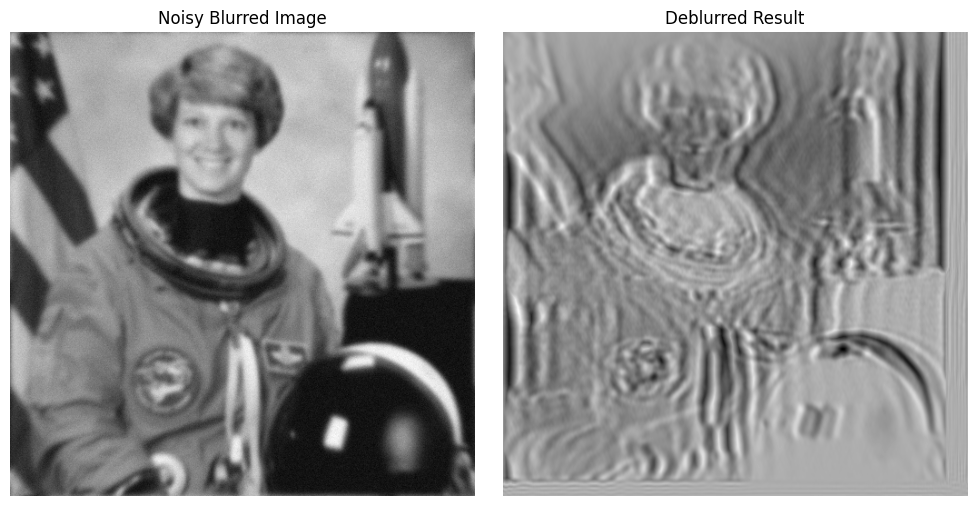

In [68]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(noisy_blurred, cmap='gray')
plt.title('Noisy Blurred Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(deblurred, cmap='gray')
plt.title('Deblurred Result')
plt.axis('off')

plt.tight_layout()
plt.show()


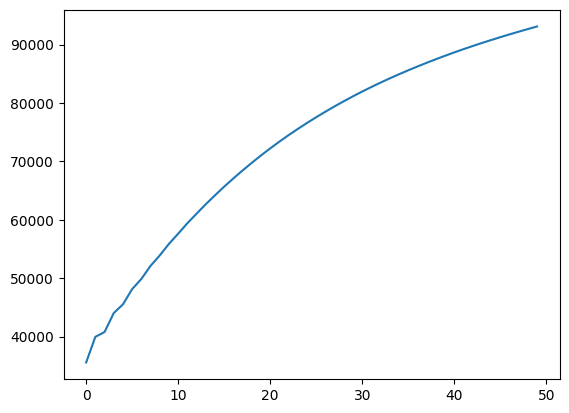

In [69]:
plt.plot(solver.losses['total'])

In [3]:
import numpy as np
np.array([-1,1]).reshape(1,-1)

array([[-1,  1]])